# Imports

In [1]:
pip install scikit-learn==0.23.1

In [2]:
pip install imbalanced-learn

In [3]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
# import mlrose

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
import marshal
from typing import Union

from matplotlib import pyplot as plt
from matplotlib import rcParams

import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocessing

## Load data

In [6]:
maintained_df: pd.DataFrame = pd.read_csv(
    '/content/drive/MyDrive/thesis/datasets/maintained.csv'
)
maintained_df.shape

(3305, 30)

In [7]:
unmaintained_df: pd.DataFrame = pd.read_csv(
    '/content/drive/MyDrive/thesis/datasets/unmaintained.csv'
)
unmaintained_df.shape

(5715, 30)

## Fixing

In [8]:
# Drop duplicates

# maintained_df.drop_duplicates(
#     subset=['repo_name'], keep='last', inplace=True, ignore_index=True
# )
# unmaintained_df.drop_duplicates(
#     subset=['repo_name'], keep='last', inplace=True, ignore_index=True
# )

# maintained_df.shape, unmaintained_df.shape

In [9]:
# Remove 'Could not compute'

# maintained_df = maintained_df[
#     ~maintained_df['last_commit_age'].str.contains('Could')
# ]
# unmaintained_df = unmaintained_df[
#     ~unmaintained_df['last_commit_age'].str.contains('Could')
# ]
# # unmaintained_df.dropna(how='any', inplace=True, subset=['last_commit_age'])

# maintained_df.shape, unmaintained_df.shape

In [10]:
# maintained_df.to_csv(
#     '/content/drive/MyDrive/thesis/datasets/maintained.csv',
#     sep=',',
#     index=False
# )
# unmaintained_df.to_csv(
#     '/content/drive/MyDrive/thesis/datasets/unmaintained.csv',
#     sep=',',
#     index=False
# )

In [11]:

# # main_set = set(main_ext_df['repo_name'])
# unmain_set = set(unmain_ext_df['repo_name'])

# with open(file='/content/drive/MyDrive/thesis/datasets/unmaintained_names.dat', mode='wb') as f:
#     marshal.dump(main_set, f)

In [12]:
# maintained_df.drop('productive_duration', axis=1, inplace=True)
# unmaintained_df.drop('productive_duration', axis=1, inplace=True)

## Correlated columns

In [13]:
# rcParams['figure.figsize'] = 10, 10

# ax = sns.heatmap(
#     unmaintained_df.corr(), vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     xticklabels=True, yticklabels=True, square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(), rotation=45, horizontalalignment='right'
# );

In [14]:
def correlated_columns(dataset: pd.DataFrame, threshold: float) -> list:
    corr_matrix = dataset.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
    )

    correlated_columns = [
        col for col in upper_triangle.columns
        if any(upper_triangle[col] > threshold)
    ]
    return correlated_columns

In [15]:
correlated_columns(dataset=unmaintained_df, threshold=0.9)

['issues_count_open', 'stargazers_count', 'devs_following_avg', 'wealth']

In [16]:
correlated_columns(dataset=unmaintained_df, threshold=0.9)

['issues_count_open', 'stargazers_count', 'devs_following_avg', 'wealth']

In [17]:
correlated_cols = correlated_columns(dataset=unmaintained_df, threshold=0.9)

maintained_df = maintained_df.drop(columns=correlated_cols)
unmaintained_df = unmaintained_df.drop(columns=correlated_cols)

maintained_df.shape, unmaintained_df.shape

((3305, 26), (5715, 26))

### Encoding

In [18]:
cols_to_encode = ['owner_type', 'has_test', 'has_doc', 'has_example', 'has_readme']
cols_to_drop = ['repo_name', 'url']

maintained_df.drop(columns=cols_to_drop, axis=1, inplace=True)
unmaintained_df.drop(columns=cols_to_drop, axis=1, inplace=True)

maintained_df = pd.get_dummies(data=maintained_df, columns=cols_to_encode)
unmaintained_df = pd.get_dummies(data=unmaintained_df, columns=cols_to_encode)

In [19]:
maintained_df.shape, unmaintained_df.shape

((3305, 29), (5715, 29))

## Compute centroid

In [20]:
def compute_centroid(dataset: np.ndarray) -> np.ndarray:
    model = KMeans(n_clusters=1)
    model.fit(X=dataset)
    return model.cluster_centers_

In [21]:
outlier_labels = IsolationForest(
    n_jobs=-1
).fit_predict(X=unmaintained_df)

unmaintained_df_noout = unmaintained_df[outlier_labels > 0]

centroid = compute_centroid(dataset=unmaintained_df_noout)

In [22]:
unmaintained_df_noout.shape

(5369, 29)

## Split

In [23]:
def transform_dataframe(dataset: pd.DataFrame) -> np.ndarray:
    all_cols_to_encode = [
        'owner_type', 'has_test', 'has_doc', 'has_example', 'has_readme'
    ]

    cols_to_scale = [
        'pulls_count_open', 'pulls_count_closed', 'issues_count_closed',
        'commits_count', 'branches_count', 'releases_count', 'watchers_count',
        'forks_count', 'development_time', 'owner_account_age',
        'avg_dev_account_age', 'owner_projects_count', 'owner_following',
        'owner_followers', 'devs_followers_avg',
        'commits_by_dev_with_most_commits', 'magnetism', 'stickiness',
        'last_commit_age'
    ]

    transformer = ColumnTransformer([
        ('StScaler', StandardScaler(), cols_to_scale)
    ], remainder='passthrough')

    return transformer.fit_transform(X=dataset)


In [24]:
X_train_df, X_test_df = train_test_split(
    maintained_df, test_size=0.2, random_state=2
)

# transformuje sa to osobitne aby v test sete nebola ziadna informacia z train setu
# napr hranicne hodnoty, priemery, atd
X_train = transform_dataframe(dataset=X_train_df)
X_test = transform_dataframe(dataset=X_test_df)

X_train.shape, X_test.shape

((2644, 29), (661, 29))

## Label

In [25]:
def create_labels(X: np.ndarray, centroid: np.ndarray) -> np.ndarray:

    # dostanem riadok
    distances = pairwise_distances(X=X, Y=centroid, metric='l2')
    # spravim z toho stlpec
    distances = distances.reshape(distances.shape[0], 1)
    # ten stlpec pripojim k matici
    X_d = np.append(arr=X, values=distances, axis=1)

    # hranice pre IQR
    lower_bound, upper_bound = outlier_ranges(dataset=distances)
    # vyhodim riadky z matice ktore nespadaju do IQR hranic
    X_r = X_d[
        (X_d[:, X_d.shape[1] - 1] > lower_bound) & \
        (X_d[:, X_d.shape[1] - 1] < upper_bound)
    ]

    _, edges = np.histogram(a=X_r[:, -1], bins=5)
    # _, edges = np.histogram(a=X_d[:, -1], bins=5)

    # idem po riadkoch
    for i in range(X_d.shape[0]):
        # vezmem poslednu hodnotu riadka
        distance = X_d[i, -1]
        # vypocitam label
        label = np.searchsorted(a=edges, v=distance, side='left')
        # jedna vzorka bude mat 0, ta je tu osetrena
        if label == 0:
            label = 1
        if label > 5:
            label = 5

        # v podstate na koniec kazdeho riadku pripojim label
        X_d[i, X_d.shape[1] - 1] = label

    # vrati to dve veci, maticu bez lablov (co je posledny stlpec) a stlpec lablov
    return X_d[:, :-1], X_d[:, -1]

def outlier_ranges(dataset: np.ndarray) -> Union[float, float]:
    dataset.sort()
    Q1, Q3 = np.percentile(dataset, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)

    return lower_range, upper_range

In [47]:
def labels_count_chart(y: np.ndarray) -> None:
    plt.bar(
        x=['1', '2', '3', '4', '5'],
        height=np.histogram(a=y, bins=5)[0]
    )

In [26]:
X_train, y_train = create_labels(X=X_train, centroid=centroid)
X_test, y_test = create_labels(X=X_test, centroid=centroid)

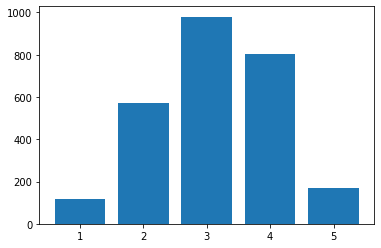

In [48]:
labels_count_chart(y=y_train)

In [ ]:
undersample_labes = {2: 300, 3: 300, 4: 300}

rus = RandomUnderSampler(sampling_strategy=undersample_labes)
X_und, y_und = rus.fit_resample(X=X_train, y=y_train)

X_train_bal, y_train_bal = SMOTE().fit_resample(X=X_und, y=y_und)

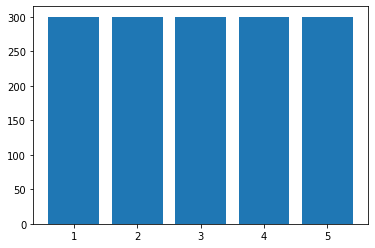

In [49]:
labels_count_chart(y=y_train_bal)

## Saving and loading matrices

In [31]:
matrices = [
    ('X_train', X_train), ('y_train', y_train),
    ('X_test', X_test), ('y_test', y_test),
    ('X_train_bal', X_train_bal), ('y_train_bal', y_train_bal)
]

In [32]:
for m in matrices:
    with open(f'/content/drive/MyDrive/thesis/datasets/{m[0]}.npy', 'wb') as f:
        np.save(f, m[1])

# Training

## Model upload and download

In [ ]:
import pickle

def save_model(model, file):
    with open(file, 'wb') as f:
        pickle.dump(model, f)

def load_model(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

## Parameters for grid search

In [ ]:
# - svm
# - naive bayes
# - rf -> absolute majority
# - dt
# - knn
# 	-> these have default parameters from scikit
# - decart
# - multiple linear regression

In [134]:
from hyperopt import fmin, hp, tpe, space_eval
from hyperopt.pyll import scope

from numpy import load, ndarray
from typing import Dict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [74]:
X_train = load('/content/drive/MyDrive/thesis/datasets/X_train.npy')
y_train = load('/content/drive/MyDrive/thesis/datasets/y_train.npy')
X_train_bal = load('/content/drive/MyDrive/thesis/datasets/X_train_bal.npy')
y_train_bal = load('/content/drive/MyDrive/thesis/datasets/y_train_bal.npy')
X_test = load('/content/drive/MyDrive/thesis/datasets/X_test.npy')
y_test = load('/content/drive/MyDrive/thesis/datasets/y_test.npy')

In [75]:
rf_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 500, 1)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'max_features': hp.pchoice('max_features', [
        (0.5, 'sqrt'),
        (0.25, 'log2'),
        (0.25, None),
    ]),
    # class_weight? balanced?
}

knn_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 1, 50, 1)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice(
        'algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']
    )
}

svc_space = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'probability': True
}

dt_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1))
}

In [76]:
def score(estimator, X: ndarray, y: ndarray) -> float:
    return cross_val_score(
        estimator=estimator, X=X, y=y, scoring='roc_auc_ovr'
    ).mean()

In [141]:
classifiers = {
    'rf': ('rf', RandomForestClassifier, rf_space),
    'knn': ('knn', KNeighborsClassifier, knn_space),
    'svc': ('svc', SVC, svc_space),
    'dt': ('dt', DecisionTreeClassifier, dt_space),
    # 'nb': ('nb', CategoricalNB, None)
}

def best_params(X: ndarray, y: ndarray, clfs: Dict) -> Dict:
    best_params = dict()

    for _, clf_tuple in clfs.items():

        if clf_tuple[0] == 'nb':
            best_params[clf_tuple[0]] = None
            continue

        def objective(params: Dict) -> float:
            clf = clf_tuple[1](**params)
            clf.fit(X=X, y=y)

            return 1.0 - score(estimator=clf, X=X, y=y)

        params = fmin(
            fn=objective, space=clf_tuple[2], algo=tpe.suggest, max_evals=10
        )

        best_params[clf_tuple[0]] = params

    return best_params

In [139]:
def compute_AUCs(
    X_train: ndarray, y_train: ndarray,
    X_test: ndarray, y_test: ndarray,
    clfs: Dict, best_params: Dict, postfix: str
) -> Dict:
    results = dict()
    
    for _, clf_tuple in clfs.items():

        if clf_tuple[0] == 'nb':
            clf = clf_tuple[1]()
        else:
            params = space_eval(
                space=clf_tuple[2], hp_assignment=best_params[clf_tuple[0]]
            )
            clf = clf_tuple[1](**params)

        clf.fit(X=X_train, y=y_train)
        
        results[clf_tuple[0]+'_'+postfix] = score(
            estimator=clf, X=X_test, y=y_test
        )

    return results

In [ ]:
params_unbal = best_params(X=X_train, y=y_train, clfs=classifiers)
res_unbal = compute_AUCs(
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    clfs=classifiers, best_params=params_unbal,
    postfix='unbal'
)

params_bal = best_params(X=X_train_bal, y=y_train_bal, clfs=classifiers)
res_bal = compute_AUCs(
    X_train=X_train_bal, y_train=y_train_bal,
    X_test=X_test, y_test=y_test,
    clfs=classifiers, best_params=params_bal,
    postfix='bal'
)

res_all = {**res_unbal, **res_bal}

In [50]:
from matplotlib import rcParams
from numpy import round
from pandas import DataFrame
from sklearn.dummy import DummyClassifie

# Results

In [80]:
results = {
    'kNN': (res_all['knn_unbal'], res_all['knn_bal']),
    'RandomForest': (res_all['rf_unbal'], res_all['rf_bal']),
    'DecisionTree': (res_all['dt_unbal'], res_all['dt_bal']),
    'SVC': (res_all['svc_unbal'], res_all['svc_bal']),
    'NaiveBayes': (res_all['nb_unbal'], res_all['nb_bal'])
}
results

{'DecisionTree': (0.8859316522021145, 0.8552611393728322),
 'NaiveBayes': (0.7044230100089809, 0.7044230100089809),
 'RandomForest': (0.9685335931636271, 0.9677809593569953),
 'SVC': (0.9897246046987526, 0.9898327602985961),
 'kNN': (0.9285037931348729, 0.9289807284309346)}

In [83]:
def res_to_df(data: Dict) -> DataFrame:
    return DataFrame.from_dict(
        data, orient='index',
        columns=['AUC - unbalanced', 'AUC - balanced']
    )

In [84]:
results_df = res_to_df(data=results)

In [85]:
def auc_plot(data: DataFrame) -> None:
    ax = data.plot(kind='bar', xlabel='Model', ylabel='AUC', rot=0)
    for p in ax.patches:
        ax.annotate(
            round(p.get_height(), decimals=3),
            (p.get_x() + p.get_width()/2., p.get_height()),
            ha='center', va='center', xytext=(0, 5), textcoords='offset points'
        )
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

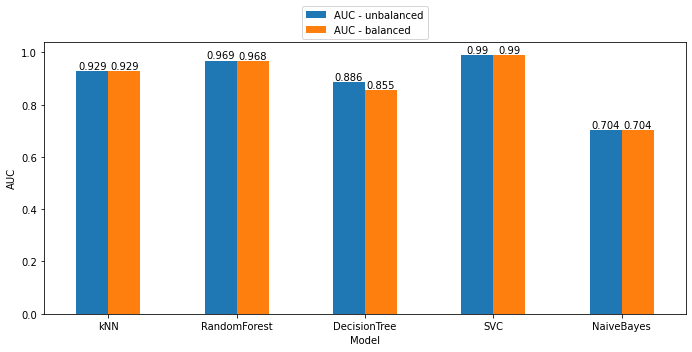

In [86]:
rcParams['figure.figsize'] = 11.5, 5

auc_plot(data=results_df)

In [63]:
bs_clfs = {
    'Stratified': 'stratified',
    'MostFrequent': 'most_frequent'
}
baseline_results = dict()

for name, clf in bs_clfs.items():
    bl_clf = DummyClassifier(strategy=clf)

    bl_clf.fit(X=X_train, y=y_train)
    res_unbal = score(estimator=bl_clf, X=X_test, y=y_test)

    bl_clf.fit(X=X_train_bal, y=y_train_bal)
    res_bal = score(estimator=bl_clf, X=X_test, y=y_test)

    baseline_results[name] = (res_unbal, res_bal)

baseline_results

{'MostFrequent': (0.5, 0.5),
 'Stratified': (0.4895519258857881, 0.5080314887099524)}

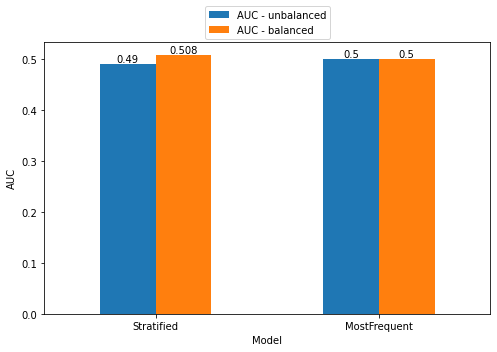

In [72]:
rcParams['figure.figsize'] = 8, 5

baseline_results_df = res_to_df(data=baseline_results)
auc_plot(data=baseline_results_df)

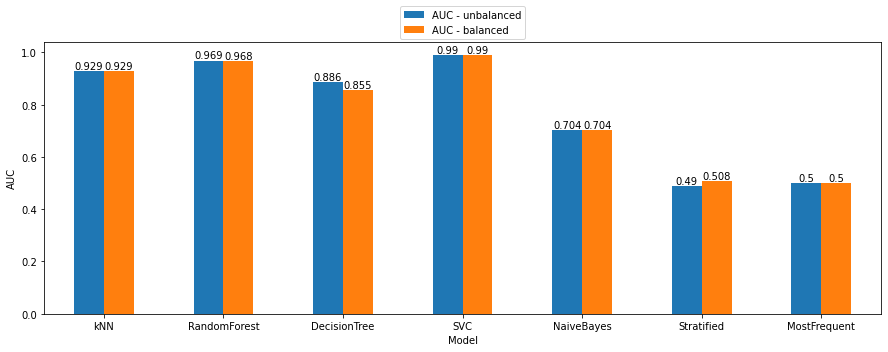

In [93]:
rcParams['figure.figsize'] = 15, 5

all_res_df = pd.concat([results_df, baseline_results_df])

auc_plot(data=all_res_df)

# Most important features

In [146]:
def best_params(name: str) -> Dict:
    return space_eval(
        space=classifiers[name][2], hp_assignment=params_bal[name]
    )

In [148]:
columns = [
    'pulls_count_open', 'pulls_count_closed', 'issues_count_closed',
    'commits_count', 'branches_count', 'releases_count', 'watchers_count',
    'forks_count', 'development_time', 'owner_account_age',
    'avg_dev_account_age', 'owner_projects_count', 'owner_following',
    'owner_followers', 'devs_followers_avg',
    'commits_by_dev_with_most_commits', 'magnetism', 'stickiness',
    'last_commit_age', 'owner_type_0', 'owner_type_1', 'has_test_False',
    'has_test_True', 'has_doc_False', 'has_doc_True', 'has_example_False',
    'has_example_True', 'has_readme_False', 'has_readme_True'
]

def feature_importance_plot(feature_importances) -> None:
    plt.bar(x=columns, height=feature_importances)
    plt.xticks(rotation=90)

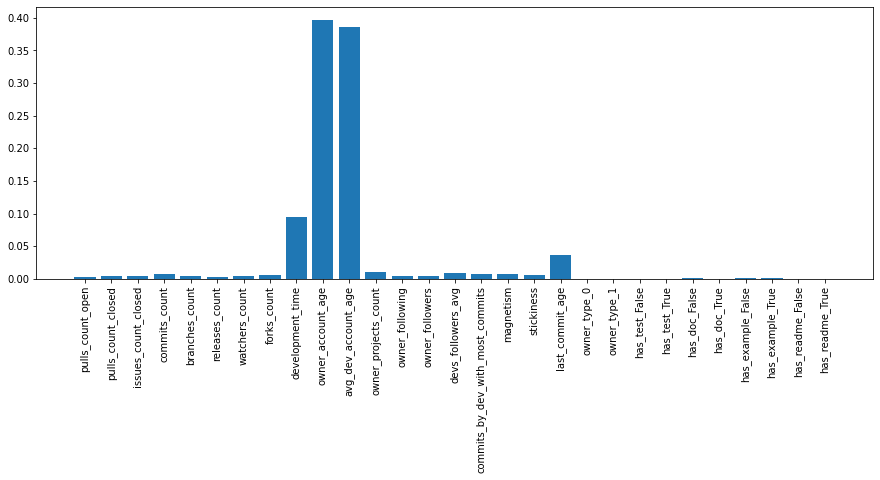

In [149]:
params = best_params(name='rf')

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X=X_test, y=y_test)

feature_importance_plot(feature_importances=rf_clf.feature_importances_)

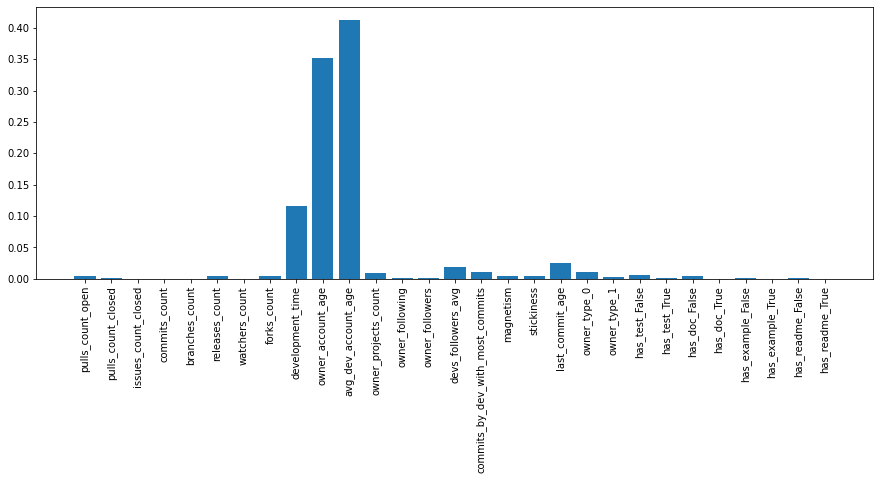

In [150]:
params = best_params(name='dt')

dt_clf = DecisionTreeClassifier(**params)
dt_clf.fit(X=X_test, y=y_test)

feature_importance_plot(feature_importances=dt_clf.feature_importances_)

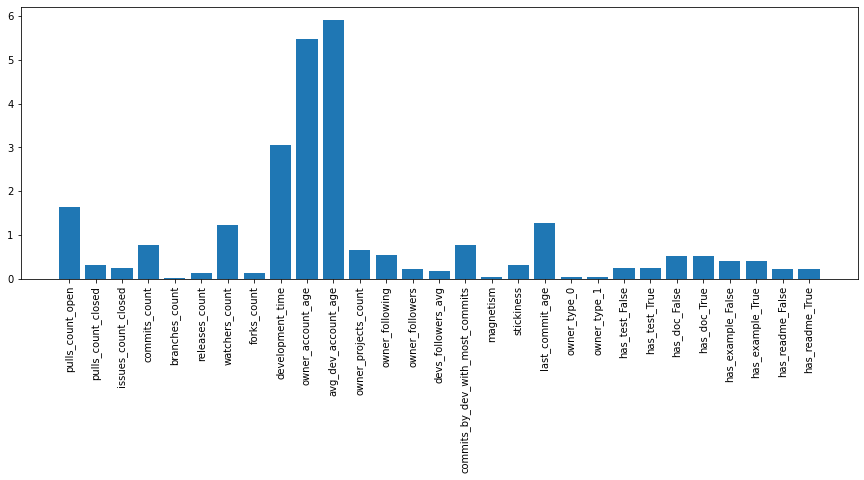

In [151]:
params = best_params(name='svc')

svc_clf = SVC(**params)
svc_clf.fit(X=X_test, y=y_test)

feature_importance_plot(feature_importances=abs(svc_clf.coef_[0]))